In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import scipy
import seaborn as sns
import matplotlib.font_manager as fm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import random
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import learning_curve


Bad key text.latex.preview in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [2]:
warnings.simplefilter('ignore')

In [14]:
df = pd.read_csv('./data/Before_Encoding_5000.csv', encoding='euc-kr')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Building_Age                 5000 non-null   int64  
 1   JS_Price                     5000 non-null   int64  
 2   JS_BA                        5000 non-null   float64
 3   Population                   5000 non-null   int64  
 4   UR                           5000 non-null   float64
 5   LC_index                     5000 non-null   float64
 6   CA_index                     5000 non-null   float64
 7   TC_index                     5000 non-null   float64
 8   SDT_index                    5000 non-null   float64
 9   HSP_index                    5000 non-null   float64
 10  Sell_Price                   5000 non-null   float64
 11  Crime_Rates                  5000 non-null   float64
 12  IR                           5000 non-null   float64
 13  Region_Name       

## Categorical:

- Nominal(variables that have two or more categories, but which do not have an intrinsic order.)

    - Region_Name : 자치구 명
    - Building_Use : 건물 용도
    
- Ordinal(variables that have two or more categories just like nominal variables. Only the categories can also be ordered or ranked.)

    
## Numeric:

- Discrete
    - YearMonth : 년월
    - Building_Age : 건물연식
    - JS_Price : 전세가
   
- Continous
    - Sell_Price : 매매 가격
    - JS_BA = JS_Building Area : 임대 면적
    - lR = Interest Rate : 금리
    - UR = Unemployment Rate : 실업률
    - LC_index = Leading Composite index : 선행종합 지수
    - CA_index = Comprehensive Accompany index : 동행종합 지수
    - TC_index = Trailing Composite index : 후행종합 지수
    - SDT_index = Supply and Demand Trend index = 전세수급동향 지수
    - HSP_index = 
    - Population : 인구수
    - Crime_Rates : 범죄율
    - Shortest_Distance_to_Subway : 가장 가까운 지하철역과의 거리
    - Shortest_Distance_to_School : 가장 가까운 초중고등학교와의 거리
    - Shortest_Distance_to_Univ : 가장 가까운 대학교와의 거리
    - Shortest_Distance_to_Park : 가장 가까운 공원과의 거리
    

## 데이터 전처리

In [16]:
# 범주형 변수 리스트 지정
categorical_columns = ['Building_Use', 'Region_Name']
target_column = 'JS_Price'

# 데이터 분할
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# 학습 데이터에서 각 범주의 평균 타겟 값 계산
for categorical_column in categorical_columns:
    encoding_map = train_data.groupby(categorical_column)['JS_Price'].mean().to_dict()
    
    # 학습 데이터에 타겟 인코딩 적용
    train_data[categorical_column + '_encoded'] = train_data[categorical_column].map(encoding_map)
    
    # 테스트 데이터에도 동일한 인코딩 매핑을 적용
    test_data[categorical_column + '_encoded'] = test_data[categorical_column].map(encoding_map)
    
    # 기존 범주형 변수 삭제
    train_data.drop(columns=[categorical_column], inplace=True)
    test_data.drop(columns=[categorical_column], inplace=True)

In [17]:
# JS_Price를 4개의 범주로 나누고 기존 변수 삭제
train_data['JS_Price_Category'] = pd.cut(train_data['JS_Price'], bins=5, labels=False)
test_data['JS_Price_Category'] = pd.cut(test_data['JS_Price'], bins=5, labels=False)
train_data.drop('JS_Price', axis=1, inplace=True)
test_data.drop('JS_Price', axis=1, inplace=True)

# 오버샘플링할 데이터와 레이블을 준비합니다.
X_train = train_data.drop('JS_Price_Category', axis=1)  # 독립변수
Y_train = train_data['JS_Price_Category']  # 종속변수
X_test = test_data.drop('JS_Price_Category', axis=1)  # 테스트 독립변수
Y_test = test_data['JS_Price_Category']  # 테스트 종속변수

# RandomOverSampler를 초기화합니다.
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# 오버샘플링을 적용합니다(테스트 데이터는 일반화 성능 평가를 위해 적용X)
X_train_resampled, Y_train_resampled = oversampler.fit_resample(X_train, Y_train)

# 오버샘플링된 데이터를 새로운 데이터프레임으로 만듭니다.
train_data_resampled = pd.concat([X_train_resampled, Y_train_resampled], axis=1)

## Logistic Regression Analysis

In [18]:
selected_features = train_data_resampled.columns.tolist()
selected_features.remove('JS_Price_Category')

In [19]:
# 독립 변수 선택
X_train_resampled = train_data_resampled[selected_features]

# 데이터 표준화 (선택적)
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# 다항 로지스틱 회귀 모델 생성
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_resampled, Y_train_resampled)

# 모델 평가 (정확도 계산)
accuracy = model.score(X_test, Y_test)
print(f"모델 정확도 : {accuracy}", '\n')

# 각 클래스에 속할 확률 예측
probabilities = model.predict_proba(X_test)

# 예측 결과 클래스 (가장 높은 확률을 갖는 클래스 선택)
predicted_classes = model.predict(X_test)

# 예측된 클래스 및 확률 출력
print("---예측된 클래스---", '\n', predicted_classes, '\n')
print("---클래스별 확률---", '\n', probabilities)

모델 정확도 : 0.877 

---예측된 클래스--- 
 [0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 1 0
 0 2 0 0 2 0 0 1 0 2 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 3 0 0 0 0
 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 1 0 0 0 0 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 2 0 1 0 0 0 0 0 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 2 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 2 0 0 1 1 0 0 0 1 2 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 0 0 0 1 0 0 0 2 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 2 0 

## 교차검증
- data leakage 확인을 위해 교차검증 실행

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

# StratifiedKFold를 사용하여 k-폴드 교차 검증 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 수행 및 결과 저장
cv_scores = []
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_resampled, Y_train_resampled), 1):
    fold_X_train, fold_X_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
    fold_Y_train, fold_Y_val = Y_train_resampled[train_idx], Y_train_resampled[val_idx]
    
    model.fit(fold_X_train, fold_Y_train)
    fold_Y_pred = model.predict(fold_X_val)
    
    fold_accuracy = model.score(fold_X_val, fold_Y_val)
    cv_scores.append(fold_accuracy)
    
    print(f"Fold {i} 정확도: {fold_accuracy}")
    print(f"Fold {i} 분류 보고서:\n{classification_report(fold_Y_val, fold_Y_pred)}")

# 교차 검증 결과 출력
print("교차 검증 정확도:", cv_scores)
print("평균 교차 검증 정확도:", sum(cv_scores) / len(cv_scores))

Fold 1 정확도: 0.8818963127252565
Fold 1 분류 보고서:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       722
           1       0.75      0.76      0.76       721
           2       0.83      0.76      0.79       722
           3       0.88      1.00      0.94       721
           4       1.00      1.00      1.00       721

    accuracy                           0.88      3607
   macro avg       0.88      0.88      0.88      3607
weighted avg       0.88      0.88      0.88      3607

Fold 2 정확도: 0.8702522872192958
Fold 2 분류 보고서:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       722
           1       0.72      0.77      0.75       721
           2       0.82      0.70      0.76       721
           3       0.87      1.00      0.93       722
           4       1.00      1.00      1.00       721

    accuracy                           0.87      3607
   macro avg       0.87      0.87      

## Training and validaion accuracy
- 학습곡선으로 데이터 크기 증가에 따른 훈련데이터와 검증 데이터의 정확도를 그림으로써 모델의 과적합을 시각적으로 확인

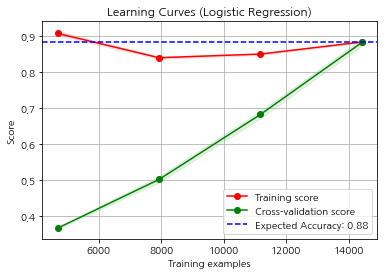

In [11]:
# 학습 곡선을 그리는 함수 정의
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # 기대 정확도 계산
    expected_accuracy = test_scores_mean[-1]  # 검증 세트의 마지막 값
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    # 기대 정확도 플롯 추가
    plt.axhline(y=expected_accuracy, color='b', linestyle='--', label=f"Expected Accuracy: {expected_accuracy:.2f}")

    plt.legend(loc="best")
    return plt

# 학습 곡선 그리기
title = "Learning Curves (Logistic Regression)"
# 모델은 이미 훈련되었다고 가정합니다 (model 변수에 저장되어 있음)
plot_learning_curve(model, title, X_train_resampled, Y_train_resampled, cv=5, n_jobs=1)

plt.show()

## 변수선택법
- 모델의 복잡성이 줄어든 상태에서 통계적 유의성을 고려하여 변수선택을 위해 다중공선성과 p-value 체크

### 다중공선성

In [12]:
# X_train_resampled을 DataFrame으로 변환
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=selected_features)

# 각 독립 변수의 VIF 계산
vif = pd.DataFrame()
vif["Features"] = X_train_resampled_df.columns
vif["VIF"] = [round(variance_inflation_factor(X_train_resampled_df.values, i), 0) for i in range(X_train_resampled_df.shape[1])]

print("독립 변수별 VIF:")
print(vif)

독립 변수별 VIF:
                       Features    VIF
0                  Building_Age    1.0
1                         JS_BA    2.0
2                    Population    2.0
3                            UR    3.0
4                      LC_index  318.0
5                      CA_index  156.0
6                      TC_index  265.0
7                     SDT_index    5.0
8                     HSP_index   24.0
9                    Sell_Price    4.0
10                  Crime_Rates    2.0
11                           IR    7.0
12                    YearMonth  112.0
13  Shortest_Distance_to_Subway    1.0
14  Shortest_Distance_to_School    1.0
15    Shortest_Distance_to_Univ    2.0
16         Building_Use_encoded    1.0
17          Region_Name_encoded    2.0


- VIF값 5를 기준으로 높으면 변수에서 제거할 요인으로 본다면 LC_index, CA_index, HSP_index, YearMonth가 제거변수

### p-value

In [13]:
# 독립 변수를 데이터프레임으로 변환
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=selected_features)

# 다항 로지스틱 회귀 모델 생성 (상수항 추가)
X_train_resampled_df = sm.add_constant(X_train_resampled_df)
model = sm.MNLogit(Y_train_resampled, X_train_resampled_df)

# 모델 피팅
result = model.fit()

# 독립 변수들의 p-value 추출
p_values = result.pvalues

# 결과 출력
print("P-values for independent variables:")
print(p_values)

Optimization terminated successfully.
         Current function value: nan
         Iterations 18
P-values for independent variables:
                              0   1   2   3
const                       NaN NaN NaN NaN
Building_Age                NaN NaN NaN NaN
JS_BA                       NaN NaN NaN NaN
Population                  NaN NaN NaN NaN
UR                          NaN NaN NaN NaN
LC_index                    NaN NaN NaN NaN
CA_index                    NaN NaN NaN NaN
TC_index                    NaN NaN NaN NaN
SDT_index                   NaN NaN NaN NaN
HSP_index                   NaN NaN NaN NaN
Sell_Price                  NaN NaN NaN NaN
Crime_Rates                 NaN NaN NaN NaN
IR                          NaN NaN NaN NaN
YearMonth                   NaN NaN NaN NaN
Shortest_Distance_to_Subway NaN NaN NaN NaN
Shortest_Distance_to_School NaN NaN NaN NaN
Shortest_Distance_to_Univ   NaN NaN NaN NaN
Building_Use_encoded        NaN NaN NaN NaN
Region_Name_encoded         Na

- a=0.05일 때, 클래스 3을 제외하고 p-value값을 고려하면 HSP_index, CA_index를 제외한다.